# Initialize notebook

In [1]:
import wandb

In [2]:
import lpips
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torchmetrics
import torchvision
from torch.utils.data import DataLoader

In [3]:
import sys
sys.path.append("/home/e/e0425222/CS4243-project")
from utils.dataset_utils.AnimalDataset import AnimalDataset
from utils.train_utils.train_utils import sample_batch, summary, visualize_adj
from utils.train_utils.model_utils import Conv2dBlock, GatedConv2d, GatedConv2dBlock, GatedUpConv2dBlock

/home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [4]:
train_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_train.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])

valid_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_val.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])

test_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_test.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])


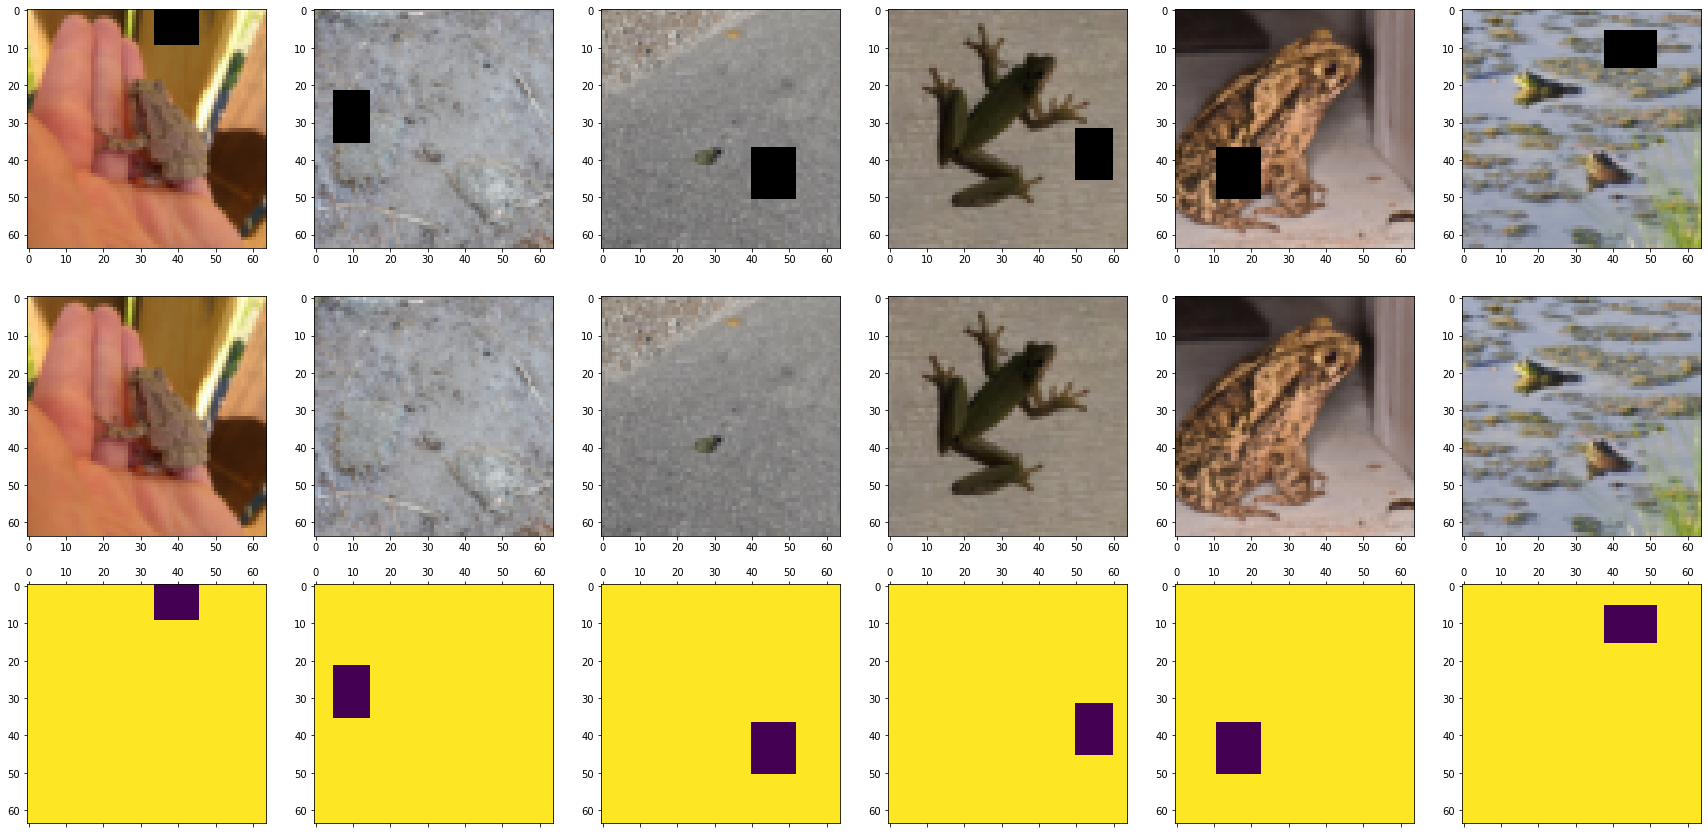

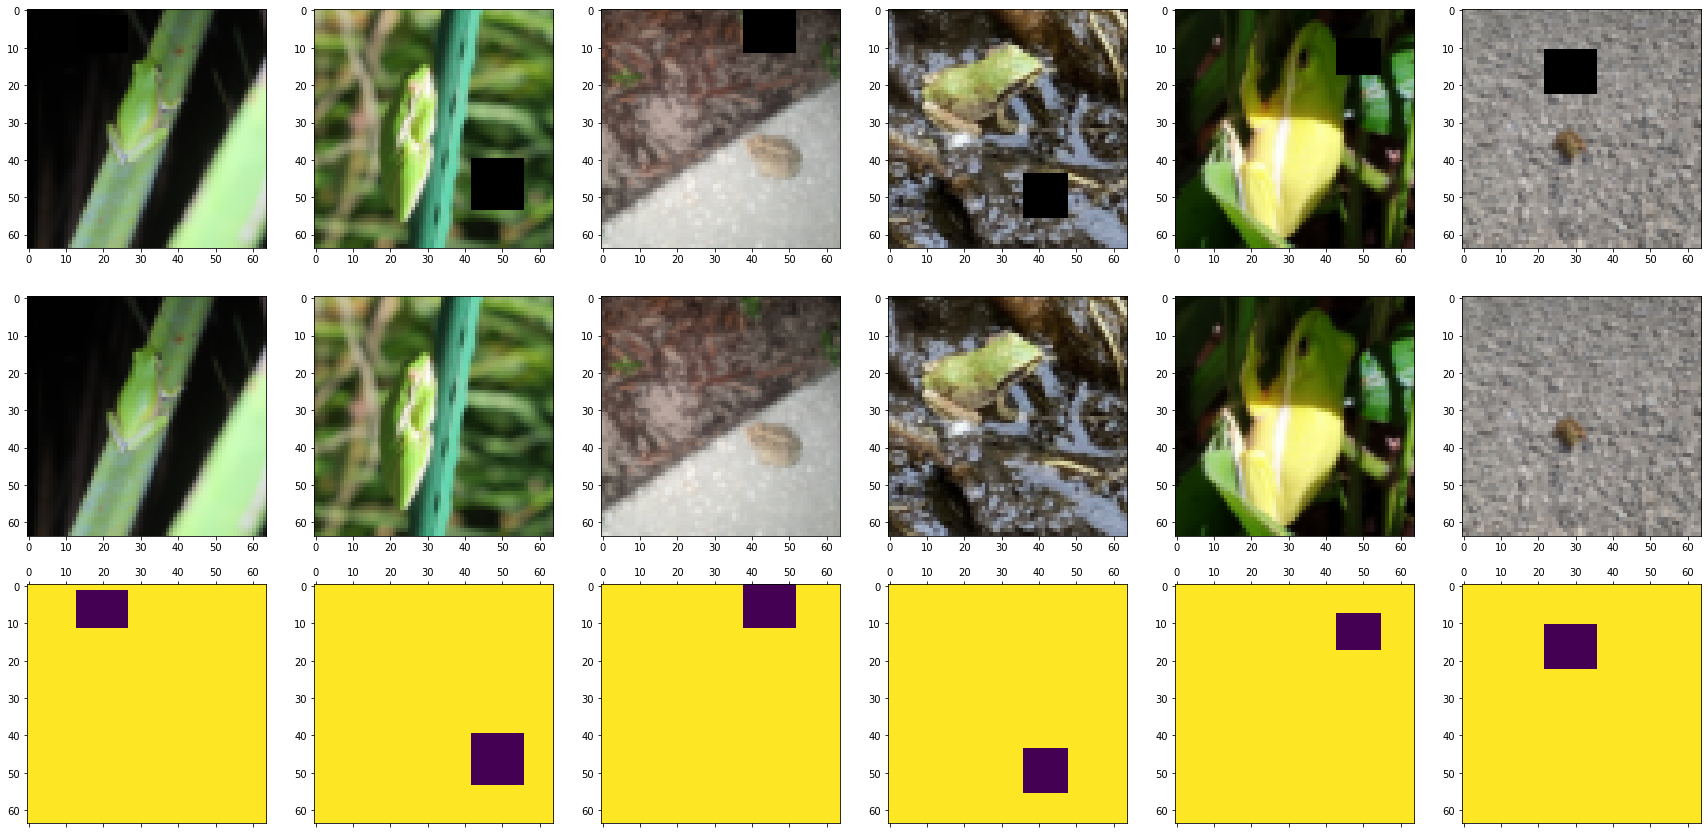

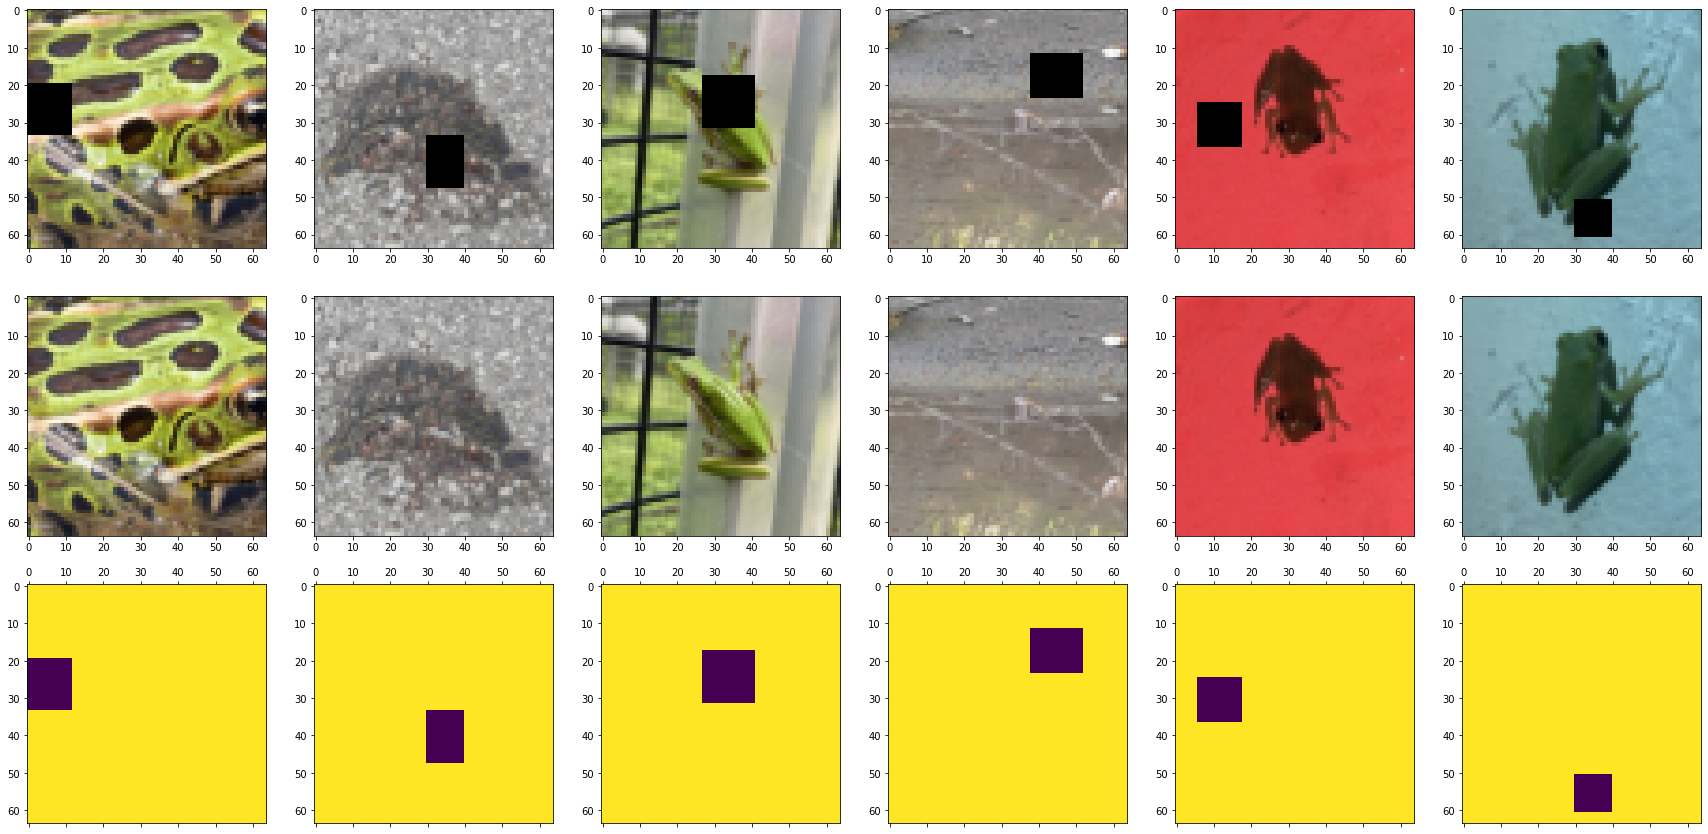

In [5]:
# sanity check 
sample_batch(train_dataset, sample_size = 6)
sample_batch(valid_dataset, sample_size = 6)
sample_batch(test_dataset, sample_size = 6)


# Introduction
This notebook aims to explore how the use of graphs to encode global information can improve capturing global context in image inpainting. The relevant references are:
1. How Powerful are Graph Neural Networks? (https://arxiv.org/abs/1810.00826)

In particular, we explore how masking the adjacency tensor by allowing only information flow from masked to non-masked regions could work.

# Model experiment


In [6]:
import torch_geometric as torch_g
import torch_geometric.nn as gnn

class GraphConvModule(nn.Module):
    """
    This module implements GIN convolution on images using local, global and channel features to predict
    the adjacency tensor.
    """

    def __init__(self, channels, kernel_size, stride, padding, dilation, activation = nn.ReLU):

        super(GraphConvModule, self).__init__()


        # incidence matrix
        self.feature_conv = nn.Conv2d(channels, channels, kernel_size = kernel_size, stride = stride, padding = 'same')
        self.channel_conv = nn.Conv2d(channels, channels, kernel_size = 1, stride = 1, padding = 'same')
        self.global_feature_conv = nn.Conv2d(channels, channels, kernel_size = kernel_size, stride = stride, padding = padding, dilation = dilation)

        # graph conv
        self.gnn_linear = nn.Sequential(
            nn.Linear(channels, channels),
            activation()
        )
        self.gnn = gnn.DenseGINConv(self.gnn_linear)

    def forward(self, input_tensor, return_adj = False):

        # metadata
        b, c, h, w = input_tensor.shape
        
        # 1. compute local and channel features, normalize
        local_features = self.feature_conv(input_tensor).view(b, c, h * w) # b x c x hw
        channel_features = torch.mean(self.channel_conv(input_tensor), dim = [2,3]).unsqueeze(-1) # b x c, global mean pool
        local_channel_features = (local_features * channel_features).permute(0, 2, 1) # -> b x hw x c
        local_channel_features = nn.functional.normalize(local_channel_features, p = 2, dim = 2) # normalize vector at each node

        # 2. compute gloabl features, normalize
        global_features = self.global_feature_conv(input_tensor).view(b, c, h * w) # b x c x hw
        global_features = nn.functional.normalize(global_features, p = 2, dim = 2) # normalize vector at each node

        # 3. predict adj tensor
        adj_tensor = torch.sigmoid(torch.bmm(local_channel_features, global_features)) # (b x hw x c) x (b x c x hw) -> (b x hw x hw)

        # 4. graph conv
        x = input_tensor.view(b, c, h*w).permute(0, 2, 1)  # -> b x hw x c
        x = self.gnn(x, adj_tensor) # -> b x hw x c

        # 5. reshape back to image
        x = x.permute(0, 2, 1).view(b, c, h, w)

        if return_adj:
            return x, adj_tensor
            
        return x

    

In [7]:
class Generator(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(Generator, self).__init__()
        
        # same -> downsample -> same -> downsample
        self.conv0 = GatedConv2dBlock(input_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv1 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv2 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv3 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)

        # graph conv
        self.graphconv1 = GraphConvModule(hidden_dim, kernel_size = 3, stride = 1, padding = 2, dilation = 2, activation = activation)

        # 2 x down conv
        self.conv4 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv5 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)

        # graph conv
        self.graphconv2 = GraphConvModule(hidden_dim, kernel_size = 3, stride = 1, padding = 2, dilation = 2, activation = activation)

        # 4 x same conv
        self.conv6 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 2, dilation = 2, activation = activation)
        self.conv7 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 4, dilation = 4, activation = activation)
        self.conv8 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 8, dilation = 8, activation = activation)
        self.conv9 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 16, dilation = 16, activation = activation)

        # 2 x up conv
        self.conv10 = GatedUpConv2dBlock(hidden_dim * 2, hidden_dim, scale_factor = (2,2), kernel_size = 3, stride = 1, padding = 1, dilation = 1, mode = 'nearest')
        self.conv11 = GatedUpConv2dBlock(hidden_dim, hidden_dim, scale_factor = (2,2), kernel_size = 3, stride = 1, padding = 1, dilation = 1, mode = 'nearest')

        # upsample -> same -> upsample -> same
        self.conv12 = GatedUpConv2dBlock(hidden_dim * 2, hidden_dim, scale_factor = (2,2), kernel_size = 3, stride = 1, padding = 1, dilation = 1, mode = 'nearest')
        self.conv13 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv14 = GatedUpConv2dBlock(hidden_dim, hidden_dim, scale_factor = (2,2), kernel_size = 3, stride = 1, padding = 1, dilation = 1, mode = 'nearest')
        self.conv15 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # final
        self.final = nn.Conv2d(hidden_dim, output_dim, kernel_size = 3, stride = 1, padding = 'same')

        # for contrastive learning, 1x1 conv to compress feature map into 1 channel
        self.conv_feature = nn.Conv2d(hidden_dim, 1, kernel_size = 1, stride = 1, padding = 'same')

    def forward(self, input_tensor, return_adj = False):

        x = self.conv0(input_tensor)
        
        # downsample
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # graph conv
        g1, adj1 = self.graphconv1(x, return_adj = True)

        # middle downsample layers
        x = self.conv4(x)
        x = self.conv5(x)

        # graph conv
        g2, adj2 = self.graphconv2(x, return_adj = True)

        # dilated conv with residual skips
        x = self.conv6(x) + x
        x = self.conv7(x) + x
        x = self.conv8(x) + x
        x = self.conv9(x) + x

        # middle upsamplelayers
        x = self.conv10(torch.cat([x, g2], dim = 1))
        x = self.conv11(x)

        # upsample
        x = self.conv12(torch.cat([x, g1], dim = 1))
        x = self.conv13(x)
        x = self.conv14(x)
        x = self.conv15(x)
        
        # final
        x = self.final(x)

        if return_adj:
            return x, adj1, adj2

        return x


class Discriminator(nn.Module):

    def __init__(self, input_dim, hidden_dim, input_shape, activation):

        super(Discriminator, self).__init__()

        # 5 layers down
        self.conv0 = Conv2dBlock(input_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv1 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv2 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv3 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv4 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)

        # linear to predict classes
        LATENT_H = input_shape//(2**5)
        self.linear = nn.Linear(LATENT_H**2 * hidden_dim, 1)


    def forward(self, input_tensor):
        
        x = self.conv0(input_tensor)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # scores
        x = torch.flatten(x, start_dim = 1)
        x = self.linear(x)

        return x


# Training configuration

In [8]:
MODEL_PARAMS = {
    "description" : """
        Base structure same as the GLCIC model. 
        Gated convolutions replace all convolutions in the generator. Additional round of downsampling.
        Graph-based features are created at each downsampling, and concatenated to corresponding
        upsampling features.""",
    "hidden_dim" : 64,
    "activation" : nn.Mish,
}

SAVE_PATHS = {
    "generator" : "/home/e/e0425222/CS4243-project/active_experiments/final/GraphGAN/Ungated/generator/generator",
    "discriminator" : "/home/e/e0425222/CS4243-project/active_experiments/final/GraphGAN/Ungated/discriminator/discriminator"
}

TRAINING_PARAMS = {
    "num_epochs" : 20,
    "batch_size" : 64, 
    "learning_rate": 1e-4,
    "alpha": 1,
    "schedule_every" : 5,
    "sample_size" : 16,
    "log_every" : 10,
    "save_paths" : SAVE_PATHS,
}

LOGGING_CONFIG = {
    "model_params" : MODEL_PARAMS,
}
LOGGING_CONFIG.update(TRAINING_PARAMS)

# Experiment intialization

In [9]:
# 1. initialize model
generator = Generator(input_dim = 4, hidden_dim = MODEL_PARAMS["hidden_dim"], output_dim = 3, activation = MODEL_PARAMS["activation"])
discriminator = Discriminator(input_dim = 3, hidden_dim = MODEL_PARAMS["hidden_dim"], input_shape = 64, activation = MODEL_PARAMS["activation"])

summary(generator)
summary(discriminator)

# 2. device
parallel = False
device = 'cuda:3'  
devices = [3,1,2,0]

if not parallel:
    generator1 = generator.to(device)
    discriminator = discriminator.to(device)
else:
    generator1 = nn.DataParallel(generator, device_ids = devices)
    discriminator = nn.DataParallel(discriminator, device_ids = devices)

# 3. initialize loss functions
recon_loss_function = lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask), gt * (1-mask), reduction = 'none').sum()/(1-mask).sum()
discriminator_loss_function = nn.functional.binary_cross_entropy_with_logits

# 4. initialize metrics
VGG_LPIPS = lpips.LPIPS(net = 'vgg').to(device)
METRICS = {
    "Peak SnR (Whole)" : lambda img, gt, mask : torchmetrics.functional.peak_signal_noise_ratio(img * (1-mask) + gt * mask, gt),
    "L2 loss (Whole)" : lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask) + gt * mask, gt),
    "L2 loss (Mask)" : lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask), gt * (1-mask), reduction = 'sum')/(1-mask).sum(),
    "L1 loss (Whole)" : lambda img, gt, mask : nn.functional.l1_loss(img * (1-mask) + gt * mask, gt),
    "L1 loss (Mask)" : lambda img, gt, mask : nn.functional.l1_loss(img * (1-mask), gt * (1-mask), reduction = 'sum')/(1-mask).sum(),
    "LPIPS (Whole)" : (lambda img, gt, mask : VGG_LPIPS(img * (1-mask) + gt * mask, gt).mean()),
}


# 5. initialize optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr = TRAINING_PARAMS["learning_rate"])
generator_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(generator_optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr = TRAINING_PARAMS["learning_rate"])
discriminator_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(discriminator_optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

# 6. wrap into training dictionary
TRAINING_PARAMS["generator_model"] = generator
TRAINING_PARAMS["generator_optimizer"] = generator_optimizer
TRAINING_PARAMS["generator_scheduler"] = generator_scheduler
TRAINING_PARAMS["discriminator_model"] = discriminator
TRAINING_PARAMS["discriminator_optimizer"] = discriminator_optimizer
TRAINING_PARAMS["discriminator_scheduler"] = discriminator_scheduler
TRAINING_PARAMS["discriminator_loss_function"] = discriminator_loss_function
TRAINING_PARAMS["recon_loss_function"] = recon_loss_function



model has 1.428228 million parameters
model has 0.150401 million parameters
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/lpips/weights/v0.1/vgg.pth


# Initialize logging

In [10]:
wandb.init(project="final", entity="cs4243_project")
wandb.config = LOGGING_CONFIG

wandb.watch(
    (generator, discriminator),
    criterion = None,
    log = 'all',
    log_freq = 1,
    idx = 0, 
    log_graph = False
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tanyjnaaman (use `wandb login --relogin` to force relogin)


[]

# Train

## Train functions

In [11]:

def train_epoch(device, train_dataloader, training_params : dict, metrics : dict, log_wandb = True):
    
    # ===== INITIALIZE =====
    # constants
    RECONSTRUCTION_LOSS = training_params["recon_loss_function"]
    DISCRIMINATOR_LOSS_FUNCTION = training_params["discriminator_loss_function"]

    GENERATOR_OPTIMIZER = training_params["generator_optimizer"]
    DISCRIMINATOR_OPTIMIZER = training_params["discriminator_optimizer"]

    BATCH_EVALUATE_EVERY = 5
    LOG_EVERY = training_params["log_every"]
    SAMPLE_SIZE = training_params["sample_size"]
    BATCH_SIZE = training_params["batch_size"]
    ALPHA = training_params["alpha"]

    # models
    generator = training_params["generator_model"].to(device).train()
    discriminator = training_params["discriminator_model"].to(device).train()

    # epoch metrics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 
    running_results["loss_discriminator"] = 0.0
    running_results["loss_generator"] = 0.0
    running_results["loss_generator_r"] = 0.0
    running_results["loss_generator_adv"] = 0.0

    # ===== TRAIN EPOCH =====
    num_batches = 0
    for _, batch in enumerate(train_dataloader, 1):

            # ===== INITIALIZE =====
            num_batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # sanity check
            assert input_batched.shape[0] == ground_truth_batched.shape[0]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)


            # reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # ===== FORWARD PASS =====

            # 1. train discriminator
            DISCRIMINATOR_OPTIMIZER.zero_grad()
            
            # 1.1 generate images
            input_batched.requires_grad_()
            output_batched = generator(input_batched)

            # 1.2 splice with ground truth
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 

            # 1.3 feed into discriminator
            label_real = torch.ones(BATCH_SIZE, 1).to(device)
            label_fake = torch.zeros(BATCH_SIZE, 1).to(device)

            pred_real = discriminator(ground_truth_batched)
            loss_real = DISCRIMINATOR_LOSS_FUNCTION(pred_real, label_real)

            pred_fake = discriminator(spliced_batched.detach())
            loss_fake = DISCRIMINATOR_LOSS_FUNCTION(pred_fake, label_fake)
            loss_d = ALPHA * (loss_real + loss_fake)
            loss_d.backward()
            DISCRIMINATOR_OPTIMIZER.step()

            # 2. train generator (reconstruction, adverserial)
            GENERATOR_OPTIMIZER.zero_grad()

            # 2.1 forward pass by generator to produce images, splice them
            output_batched, adj1, adj2 = generator(input_batched, return_adj = True)
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 
            
            # 2.2 reconstruction loss
            loss_g_reconstruction = RECONSTRUCTION_LOSS(output_batched, ground_truth_batched, mask_batched)

            # 2.3 adverserial loss
            label_real = torch.ones(BATCH_SIZE, 1).to(device)
            pred_adverserial = discriminator(spliced_batched)
            loss_g_adverserial = DISCRIMINATOR_LOSS_FUNCTION(pred_adverserial, label_real) # want it to classify all as real

            # 2.5 backprop
            loss_g = loss_g_reconstruction + ALPHA * loss_g_adverserial
            loss_g.backward()
            GENERATOR_OPTIMIZER.step()

            # ===== COMPUTE STATISTICS, USING TORCH METRICS =====  
            # 1. compute losses

            running_results["loss_generator"] += loss_g.detach().item()
            running_results["loss_generator_r"] += loss_g_reconstruction.detach().item()
            running_results["loss_generator_adv"] += loss_g_adverserial.detach().item()
            running_results["loss_discriminator"] += loss_d.detach().item()

            # 2. for each key, compute, add item to results dictionary (take average of 2 generators)
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched, mask_batched).detach().item()

            # 3. log with wandb
            if log_wandb and (num_batches % LOG_EVERY == 0):

                # generator 1
                batched_predictions = torch.cat([
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    spliced_batched[:SAMPLE_SIZE,:,:,:]], dim = 0) 
                
                image_array = torchvision.utils.make_grid(batched_predictions, nrow = SAMPLE_SIZE, padding = 50)
                images = wandb.Image(
                    image_array, 
                    caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: spliced")
                
                b, hw, hw = adj1.shape
                adj1 = visualize_adj(adj1, b, int(hw**0.5), int(hw**0.5))
                adj1_array = torchvision.utils.make_grid(adj1[:SAMPLE_SIZE].unsqueeze(1), nrow = SAMPLE_SIZE)
                adj1_images = wandb.Image(
                    adj1_array, 
                    caption = "First adjacency tensor")

                b, hw, hw = adj2.shape
                adj2 = visualize_adj(adj2, b, int(hw**0.5), int(hw**0.5))
                adj2_array = torchvision.utils.make_grid(adj2[:SAMPLE_SIZE].unsqueeze(1), nrow = SAMPLE_SIZE)
                adj2_images = wandb.Image(
                    adj2_array, 
                    caption = "Second adjacency tensor")

                # log images and some metadata
                wandb.log( {
                    "generator_train_images" : images,
                    "adj1_images" : adj1_images,
                    "adj2_images" : adj2_images,
                    "lr_generator" : GENERATOR_OPTIMIZER.param_groups[0]['lr'],
                    "lr_discriminator" : DISCRIMINATOR_OPTIMIZER.param_groups[0]['lr']

                })

                # log all metrics
                wandb.log(
                    {key : item/num_batches for key, item in running_results.items()}
                )
        
            # ===== HOUSEKEEPING =====
            del loss_g
            del loss_d
            del input_batched

            # print results every some batches
            if num_batches % BATCH_EVALUATE_EVERY == 0: 

                args = ""
                for key, _ in running_results.items():
                    args += key + ": " + str(running_results[key]/num_batches) + "   "
                print(f"\r{num_batches}/{len(train_dataloader)}: " + args, end = '', flush = True)

    # normalise numbers by batch
    for key, _ in running_results.items():
        running_results[key] /= num_batches

    return running_results




In [12]:
def evaluate_epoch(device, validation_dataloader, training_params : dict, metrics : dict, log_wandb = True):

    # ===== INITIALIZE =====
    # models
    generator = training_params["generator_model"].to(device).eval()

    # constants
    BATCH_SIZE = training_params["batch_size"]
    SAMPLE_SIZE = training_params["sample_size"]

    # epoch statistics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 

    # ===== EVALUATE EPOCH =====

    with torch.no_grad():
        batches = 0
        for index, batch in enumerate(validation_dataloader, 1):
            
            batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # ===== FORWARD PASS =====

            # 1. reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # 2. predict    
            output_batched = generator(input_batched)
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 

            # 3. evaluate
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched, mask_batched).detach().item()

            args = ""
            for key, _ in running_results.items():
                args += key + ": " + str(running_results[key]/batches) + "   "
            print(f"\r{batches}/{len(validation_dataloader)}: " + args, end = '', flush = True)

            # 4. log 
            if log_wandb:

                # generator 1
                batched_predictions = torch.cat([
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    spliced_batched[:SAMPLE_SIZE,:,:,:]], dim = 0) 
                
                image_array = torchvision.utils.make_grid(batched_predictions, nrow = SAMPLE_SIZE, padding = 50)
                images = wandb.Image(
                    image_array, 
                    caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: spliced")
                
                # log images and some metadata
                wandb.log( {
                    "generator_val_images" : images,
                })

                # log all metrics
                wandb.log(
                    {f"val_{key}" : item/batches for key, item in running_results.items()}
                )

    # normalise numbers by batch
    for key, _ in running_results.items():
        running_results[key] /= batches

    return running_results


In [13]:
def train_evaluate(device, train_dataset, validation_dataset, training_params: dict, metrics: dict, start_epoch = 0, log_wandb = True):

    # ===== INITIALIZE =====
    # constants
    NUM_EPOCHS = training_params["num_epochs"]
    BATCH_SIZE = training_params["batch_size"]
    GENERATOR_SCHEDULER = training_params["generator_scheduler"]
    DISCRIMINATOR_SCHEDULER = training_params["discriminator_scheduler"]
    SAVE_PATHS = training_params["save_paths"]
    NUM_WORKERS = 2
    START_EPOCH = start_epoch

    # models for saving
    generator = training_params["generator_model"].to(device).train()
    discriminator = training_params["discriminator_model"].to(device).train()

    # variable losses
    train_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 

    train_results["loss_discriminator"] = []
    train_results["loss_generator"] = []
    train_results["loss_generator_r"] = []
    train_results["loss_generator_adv"] = []

    eval_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 

    # dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, drop_last = True)
    validation_dataloader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, drop_last = True)

    # ===== TRAIN =====
    for epoch in range(NUM_EPOCHS):

        start = time.time()

        # train
        print(f"\n===== Epoch: {START_EPOCH + epoch + 1} ===== ")

        # train every epoch
        results = train_epoch(device, train_dataloader, training_params, metrics, log_wandb = log_wandb)
        for key, val in results.items():
            train_results[key].append(val)

        # evaluate every epoch
        print()
        results = evaluate_epoch(device, validation_dataloader, training_params, metrics, log_wandb = log_wandb)
        for key, val in results.items():
            eval_results[key].append(val)

        # ===== EPOCH RESULTS =====
        print(f"\nCompleted epoch {START_EPOCH + epoch + 1}! Took {(time.time() - start)/60} min")

        # ===== HOUSEKEEPING =====

        # scheduler every epoch
        if DISCRIMINATOR_SCHEDULER is not None:
            DISCRIMINATOR_SCHEDULER.step(eval_results["L1 loss (Mask)"][epoch])
        if GENERATOR_SCHEDULER is not None:
            GENERATOR_SCHEDULER.step(eval_results["L1 loss (Mask)"][epoch])
            
        # save every epoch
        SAVE = f"{SAVE_PATHS['generator']}_epoch{START_EPOCH + epoch + 1}.pt"
        torch.save(generator.state_dict(), SAVE)
        SAVE = f"{SAVE_PATHS['discriminator']}_epoch{START_EPOCH + epoch + 1}.pt"
        torch.save(discriminator.state_dict(), SAVE)  

        print("Saved models!")

    return train_results, eval_results

## Train

In [14]:
torch.autograd.set_detect_anomaly(True)

train_evaluate(device, train_dataset, valid_dataset, TRAINING_PARAMS, METRICS, start_epoch = 0, log_wandb = True)


===== Epoch: 1 ===== 
155/156: Peak SnR (Whole): 27.984225291590537   L2 loss (Whole): 0.0019810828545521342   L2 loss (Mask): 0.17178490512794065   L1 loss (Whole): 0.006165955371914372   L1 loss (Mask): 0.5341973802735729   LPIPS (Whole): 0.061579138593327615   loss_discriminator: 1.3961408868912728   loss_generator: 0.8695189629831622   loss_generator_r: 0.17178490512794065   loss_generator_adv: 0.6977340594414742   
15/15: Peak SnR (Whole): 30.081406275431316   L2 loss (Whole): 0.0009835746294508377   L2 loss (Mask): 0.08568930973609289   L1 loss (Whole): 0.004436736926436424   L1 loss (Mask): 0.3862832486629486   LPIPS (Whole): 0.04773357883095741    
Completed epoch 1! Took 4.713746710618337 min
Saved models!

===== Epoch: 2 ===== 
155/156: Peak SnR (Whole): 30.664272775957663   L2 loss (Whole): 0.0008610942847876539   L2 loss (Mask): 0.07472455165078563   L1 loss (Whole): 0.004197368592083935   L1 loss (Mask): 0.364225758083405   LPIPS (Whole): 0.04593351399225573   loss_discri

wandb: Network error (ReadTimeout), entering retry loop.


155/156: Peak SnR (Whole): 32.06856874035251   L2 loss (Whole): 0.0006217843406052599   L2 loss (Mask): 0.054128588495715974   L1 loss (Whole): 0.0034154296266816317   L1 loss (Mask): 0.29734678133841486   LPIPS (Whole): 0.027987192787470357   loss_discriminator: 1.3852036314625893   loss_generator: 0.7497861785273399   loss_generator_r: 0.054128588495715974   loss_generator_adv: 0.6956575901277604   
15/15: Peak SnR (Whole): 32.40736376444499   L2 loss (Whole): 0.0005766016043101748   L2 loss (Mask): 0.04972946817676226   L1 loss (Whole): 0.003287815225000183   L1 loss (Mask): 0.28359779715538025   LPIPS (Whole): 0.02660020925104618     
Completed epoch 17! Took 3.8365110834439595 min
Saved models!

===== Epoch: 18 ===== 
155/156: Peak SnR (Whole): 32.135501283214936   L2 loss (Whole): 0.0006116279015963476   L2 loss (Mask): 0.052987286640751745   L1 loss (Whole): 0.003392638180464987   L1 loss (Mask): 0.29392003032468983   LPIPS (Whole): 0.02718120374746861   loss_discriminator: 1.38

({'Peak SnR (Whole)': [27.99653440866715,
   30.667165279388428,
   31.141716834826347,
   31.352015140729073,
   31.52422989331759,
   31.246414575821316,
   30.957646932357395,
   31.14957750760592,
   31.330171988560604,
   31.371215991484814,
   31.670444231766922,
   31.908417738400974,
   32.04873087467291,
   31.89965135623247,
   31.91858160801423,
   32.00032109480638,
   32.07263738681109,
   32.13791383841099,
   32.163562481219955,
   32.175203262231285],
  'L2 loss (Whole)': [0.0019749364627596852,
   0.0008604551888614272,
   0.0007696648782047515,
   0.0007345537522222656,
   0.00070623307599304,
   0.0007563648896160511,
   0.0008030405211357925,
   0.0007687482717208182,
   0.0007372552757330525,
   0.0007292248584025612,
   0.0006811695732325554,
   0.0006447692789011993,
   0.000625247858876649,
   0.0006463478650682821,
   0.0006437173948282949,
   0.0006321531245470023,
   0.0006212115288527014,
   0.000611302129236253,
   0.0006076858691626396,
   0.00060634812446

In [15]:
torch.autograd.set_detect_anomaly(True)

train_evaluate(device, train_dataset, valid_dataset, TRAINING_PARAMS, METRICS, start_epoch = 20, log_wandb = True)


===== Epoch: 21 ===== 
155/156: Peak SnR (Whole): 32.245488382154896   L2 loss (Whole): 0.0005975496376894655   L2 loss (Mask): 0.051980961354509476   L1 loss (Whole): 0.003341594102582143   L1 loss (Mask): 0.2907064680130251   LPIPS (Whole): 0.026229554931482962   loss_discriminator: 1.3847028140098818   loss_generator: 0.7492637895768689   loss_generator_r: 0.051980961354509476   loss_generator_adv: 0.6972828276695744    
15/15: Peak SnR (Whole): 32.35696131388347   L2 loss (Whole): 0.0005816245956035952   L2 loss (Mask): 0.050899300972620645   L1 loss (Whole): 0.00327255775531133   L1 loss (Mask): 0.286306435863177   LPIPS (Whole): 0.0249430064111948   73   
Completed epoch 21! Took 3.6121307253837585 min
Saved models!

===== Epoch: 22 ===== 
155/156: Peak SnR (Whole): 32.178822055939705   L2 loss (Whole): 0.0006055565977153639   L2 loss (Mask): 0.05238109978456651   L1 loss (Whole): 0.003363293262138482   L1 loss (Mask): 0.29097091497913485   LPIPS (Whole): 0.02662422445512587   l

({'Peak SnR (Whole)': [32.24274925085214,
   32.177141409653885,
   32.29981191341694,
   32.15995316627698,
   32.25181876696073,
   32.18155566239968,
   32.22782869828053,
   32.24643978705773,
   32.261897209363106,
   32.24057291715573,
   32.24253363487048,
   32.2801308631897,
   32.260935282095886,
   32.23151996808174,
   32.26398906952296,
   32.26292207913521,
   32.263111958136925,
   32.24967211943407,
   32.316335494701676,
   32.27031589165712],
  'L2 loss (Whole)': [0.0005979367094532324,
   0.0006057966673278059,
   0.0005897317958162882,
   0.0006087893278349955,
   0.0005963781187370515,
   0.0006055879137607124,
   0.000598590006307066,
   0.0005968597397441044,
   0.0005941522311052092,
   0.0005970939867741739,
   0.0005974343099903005,
   0.0005919849085890186,
   0.0005943502024493705,
   0.0005983492734137541,
   0.0005942319037738997,
   0.0005947264953880595,
   0.0005953059696296875,
   0.0005966101911886093,
   0.0005876004163441487,
   0.000593317626715781

In [ ]:
# train_epoch(device, DataLoader(train_dataset, batch_size = 16), TRAINING_PARAMS, METRICS, log_wandb = True)
# evaluate_epoch(device, DataLoader(valid_dataset, batch_size = 16),, TRAINING_PARAMS, metrics, log_wandb = True)